In [1]:
from collections import defaultdict
from dataclasses import dataclass
import math
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np

# Bonds

In [2]:
@dataclass
class Bond:
    coupons: Dict[float, float]
    principal: float
    maturity: float
    
    @property
    def cashflows(self):
        c = defaultdict(lambda: 0, self.coupons)
        c[self.maturity] += self.principal
        return dict(c)
    
    def compute_price(self, y: float, t: float = 0) -> float:
        assert 0 <= t <= self.maturity
        return sum([c * math.exp(-y * (tc - t)) for tc, c in self.cashflows.items() if tc >= t])                 

In [3]:
def compute_yield(bond: Bond, price: float, epsilon=1e-6) -> float:
    last_y = 1000
    y = 100
    compute_residual = lambda y: price - bond.compute_price(y=y)
    r = compute_residual(y)
    while abs(r) > epsilon:
        swap = y
        if r > 0:
            y /= 2
        else:
            while r < 0:
                y = (last_y + y) * 0.5
                r = compute_residual(y)
        last_y = swap
        r = compute_residual(y)
    return y

In [4]:
bond = Bond(
    coupons={x: 5 for x in [0.5, 1, 1.5, 2, 2.5, 3]},
    principal=100,
    maturity=3,
)

In [5]:
y = compute_yield(bond, price=100)
print(f'{y * 100: .2f} % interest rate required to sell the bond at par.')

 9.76 % interest rate required to sell the bond at par.


# Interest curve

In [6]:
prices = [99.8, 99.6, 99.4, 100.27, 101.57, 103.21, 104.85, 106.36, 107.77, 84.48, 77.72]

bonds = [
    # semi annually paid bonds
    Bond(
        coupons={},
        principal=100,
        maturity=1/12,
    ),
    Bond(
        coupons={},
        principal=100,
        maturity=2/12,
    ),
    Bond(
        coupons={},
        principal=100,
        maturity=3/12,
    ),
    Bond(
        coupons={0.5: 1.5},
        principal=100,
        maturity=6/12,
    ),
    Bond(
        coupons={0.5: 2, 1: 2},
        principal=100,
        maturity=12/12,
    ),
    
    # annually_paid_bonds
    Bond(
        coupons={1: 4, 2: 4},
        principal=100,
        maturity=2,
    ),
    Bond(
        coupons={1: 4, 2: 4, 3: 4},
        principal=100,
        maturity=3,
    ),
    Bond(
        coupons={1: 4, 2: 4, 3: 4, 4: 4},
        principal=100,
        maturity=4,
    ),
    Bond(
        coupons={1: 4, 2: 4, 3: 4, 4: 4, 5: 4},
        principal=100,
        maturity=5,
    ),
    Bond(
        coupons={},
        principal=100,
        maturity=7,
    ),
    Bond(
        coupons={},
        principal=100,
        maturity=10,
    )
]

In [7]:
def bootstrap(bond, price, yields):
    all_but_last_cashflows = sum([c * math.exp(- t * yields[t]) for t, c in bond.cashflows.items() if t != bond.maturity])
    return -math.log((price - all_but_last_cashflows) / bond.cashflows[bond.maturity]) / bond.maturity

In [8]:
yields = {}
for bond, price in zip(bonds, prices):
    yields[bond.maturity] = bootstrap(bond, price, yields)

In [9]:
print('T (months) - Zero-rate yield')
for t, y in yields.items():
    print(f'{int(12 * t): 4d} {" " * 10} {y: .03%}')

T (months) - Zero-rate yield
   1             2.402%
   2             2.405%
   3             2.407%
   6             2.438%
  12             2.387%
  24             2.310%
  36             2.280%
  48             2.289%
  60             2.309%
  84             2.409%
 120             2.521%


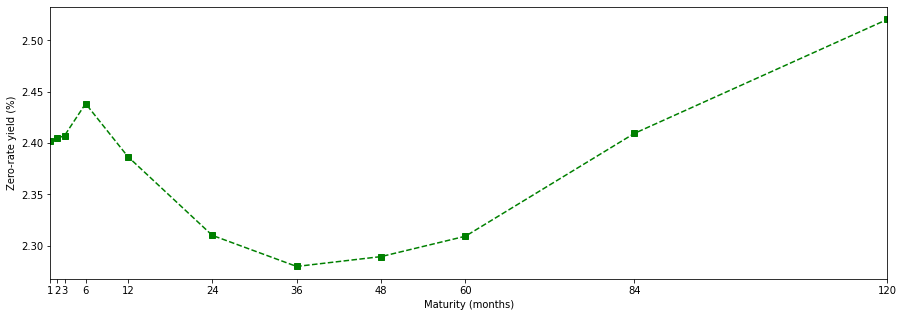

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
times = sorted(yields.keys())
months = [t * 12 for t in times]
ax.plot(months, [100 * yields[t] for t in times], 'gs--')
ax.set_xlabel('Maturity (months)')
ax.set_ylabel('Zero-rate yield (%)')
ax.set_xlim(1, 120)
ax.set_xticks(months)
plt.show()